# Machine Learning in Python - Project 2

Due Friday, April 15th by 5 pm UK local time.

Kaiqian Ji(s2178945); Kexin Lian(s2229433); Yitian Wu(s2167179); Xiaoyi Zhou(s2190991) 

## 0. Setup

In [1]:
!pip install folium
!pip install plotly.express
!pip install feature_engine
!pip install tensorflow
from tensorflow.keras.utils import to_categorical
import keras
from keras.layers import Dense
from keras.models import Sequential
from IPython.display import clear_output
# Add any additional libraries or submodules below
# Display plots inline
%matplotlib inline
# Data libraries
import pandas as pd
import numpy as np
# Plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
# Plotting defaults
plt.rcParams['figure.figsize'] = (8,5)
plt.rcParams['figure.dpi'] = 80
import folium
import plotly.express as px
import scipy.stats as stats
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier   #KNN
from sklearn.metrics import confusion_matrix   
from sklearn.metrics import classification_report
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler # scaling features
from sklearn.pipeline import Pipeline            # combining classifier steps
import warnings # prevent warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, KFold, StratifiedKFold
from feature_engine.transformation import LogTransformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from scipy.stats.distributions import loguniform
from sklearn.metrics import roc_curve, precision_recall_curve
from sklearn.metrics import roc_auc_score
clear_output()

In [2]:
""" import os
from google.colab import drive

drive.mount('/content/drive')
os.chdir('drive/My Drive/Colab Notebooks/mlp/proj2')
!ls """

" import os\nfrom google.colab import drive\n\ndrive.mount('/content/drive')\nos.chdir('drive/My Drive/Colab Notebooks/mlp/proj2')\n!ls "

In [3]:
# Load data
d = pd.read_csv("hotel.csv")

## 1. Introduction

In this project, we are primarily interested in the accuracy of the model and understanding what aspects of a booking affect the likelihood of it being canceled. We were first going to preprocess the data. When solving the problems of missing data, whether we transferred the null into the new classification or deleted the NA depends on the characteristics of the variable. Then we checked the duplication and extreme value. After the data preprocessing, there were 119203 data and 29 features in the original dataset.

In the exploratory data analysis, we took time, geography, and other factors into consideration. In terms of time characteristics, the frequency of cancelation follows a seasonal pattern distinctly. Considering the guests from different countries, Countries that are closer to the hotels are likely to show lower cancellation rates.

According to the correlation matrix, we did not find the highly correlated values. The most highly correlated variable of `is_cancled` is `lead_time`, `total_of_special_requests` and `previous_cancelations` also have a high degree of correlation.

We chose 14 numerical variables and 15 categorical variables. The test set was split from data with a 30% probability.In the prediction of the cancelation, we built on our prediction model of logistic regression,and random forest. SVM is not used considering  the speed of model computation. At the same time, we also try ANN. Because the model needs to be interpreted and the neural network model data black-box model, it is not finally applicable in the report.

Random forest performed best in the prediction and the accuracy of the model reached 89% and we can conclude the positive or negative effects.

After the prediction, we analyzed the potential gains for the hotel predicted as an inexistent cancelation and the potential losses predicted as an inexistent order. Note that we got variables `stays_in_weekend_nights` and `adr`, we calculated that the final gains were 877287 and the losses are 1358860.

## 2. Exploratory Data Analysis and Feature Engineering

Before the model fitting, we need to explore and check our dataset. We could obtain more
detailed information from the dataset, which would be helpful for us to find a better model and
to achieve our goal. And we can also spot anomalies from the dataset. Besides, by exploratory
data analysis, we might find some potential patterns in the data and then improve our model
hypothesis.

In [4]:
# The basic descrpition of the data.
d.describe()

,is_canceled,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,agent,company,days_in_waiting_list,adr,required_car_parking_spaces,total_of_special_requests
count,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119386.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,103050.000000,6797.000000,119390.000000,119390.000000,119390.000000,119390.000000
mean,0.370416,104.011416,2016.156554,27.165173,15.798241,0.927599,2.500302,1.856403,0.103890,0.007949,0.031912,0.087118,0.137097,0.221124,86.693382,189.266735,2.321149,101.831122,0.062518,0.571363
std,0.482918,106.863097,0.707476,13.605138,8.780829,0.998613,1.908286,0.579261,0.398561,0.097436,0.175767,0.844336,1.497437,0.652306,110.774548,131.655015,17.594721,50.535790,0.245291,0.792798
min,0.000000,0.000000,2015.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,6.000000,0.000000,-6.380000,0.000000,0.000000
25%,0.000000,18.000000,2016.000000,16.000000,8.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,9.000000,62.000000,0.000000,69.290000,0.000000,0.000000
50%,0.000000,69.000000,2016.000000,28.000000,16.000000,1.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,14.000000,179.000000,0.000000,94.575000,0.000000,0.000000
75%,1.000000,160.000000,2017.000000,38.000000,23.000000,2.000000,3.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,229.000000,270.000000,0.000000,126.000000,0.000000,1.000000
max,1.000000,737.000000,2017.000000,53.000000,31.000000,19.000000,50.000000,55.000000,10.000000,10.000000,1.000000,26.000000,72.000000,21.000000,535.000000,543.000000,391.000000,5400.000000,8.000000,5.000000


### 2.1 Data Preprocessing

Firstly, check the missing data in the data.

In [5]:
d.isnull().sum()

is_canceled                            0
hotel                                  0
lead_time                              0
arrival_date_year                      0
arrival_date_month                     0
arrival_date_week_number               0
arrival_date_day_of_month              0
stays_in_weekend_nights                0
stays_in_week_nights                   0
adults                                 0
children                               4
babies                                 0
meal                                   0
country                              488
market_segment                         0
distribution_channel                   0
is_repeated_guest                      0
previous_cancellations                 0
previous_bookings_not_canceled         0
reserved_room_type                     0
assigned_room_type                     0
booking_changes                        0
deposit_type                           0
agent                              16340
company         

There are 4 variables which are `country`, `agent`, `children` and `company` have missing value. In `country`, `agent` and `company`, the Null value means the individual person with no agent and unknown country, so we replace the Null values.

In [6]:
# Changing agent value of "Null" to "Individual":
d["agent"].fillna("Individual", inplace = True)
# Changing company value of "NULL" to "No Company":
d["company"].fillna("No Company", inplace = True)
# Replacing null value for country feature with "unknown"
d["country"].fillna("unknown", inplace=True)

However, except for the three variables above, we can find that variable `children` also has NA. Since there are only 4 NAs in the dataset, we delete them directly.

In [7]:
d.dropna(subset=['children'], inplace=True)

Also, the variable `meal`, `market_segment` and `distribution_channel` also have **undefined** value in the dataset.

For the variable meal, we can transfer it to `SC`. For the variable `market_segment` and `distribution_channel`, `market_segment` only has two **undefined** cases and distribution_channel has five **undefined** cases. Both of them account for less than 0.01% of the data, so we can also delete them directly.

In [8]:
d['meal'].replace(to_replace='Undefined', value='SC', inplace=True)
d = d.loc[d['market_segment']!='Undefined']
d = d.loc[d['distribution_channel']!='Undefined']

Apart from the missing data above, 180 rows contain entries with 0 adult, 0 children and 0 baby. Because the three variables are impossible to be 0 at the same case, the row need to be deleted from the original data.

In [9]:
# rows contain entries with 0 adult, 0 children and 0 baby
zero_custom = (d.adults ==0)&(d.children ==0)&(d.babies ==0)
# Delete the rows
d = d[~zero_custom]

In [10]:
# Checking that no missing values remain:
d.isnull().sum().sum()

0

Then we check for duplicates. Our dataset contains some duplicates. But it is possible that multiple booking with the same features appears on the same day. We can not confirm that those are true duplicates and we will keep them in our dataset.

In [11]:
d.duplicated().sum()

32238

Finally, detect the extreme values. Beacuse only numerical variables have the boxplot, we should distingush the categorical variables and numerical variables. Finally, we can get 15 categorical variables and 14 numerical variables.

In [12]:
# separate type integer/float and type object
obj_cols =['arrival_date_year', 'arrival_date_week_number','arrival_date_day_of_month','hotel','arrival_date_month','meal','market_segment','distribution_channel',
'is_repeated_guest','reserved_room_type','assigned_room_type','deposit_type','agent','company','country','customer_type']
num_cols = ['lead_time','stays_in_weekend_nights','stays_in_week_nights','adults','children','babies','previous_cancellations','previous_bookings_not_canceled','booking_changes','days_in_waiting_list','adr','required_car_parking_spaces','total_of_special_requests']

In [13]:
d_num = d[num_cols]

Some numerical variabales are discrete variables, so we pick up the variables `lead_time` and `adr` that can draw the boxplot.

In [14]:
boxplot_cols = ['lead_time', 'adr']
d_boxplot = d[boxplot_cols]

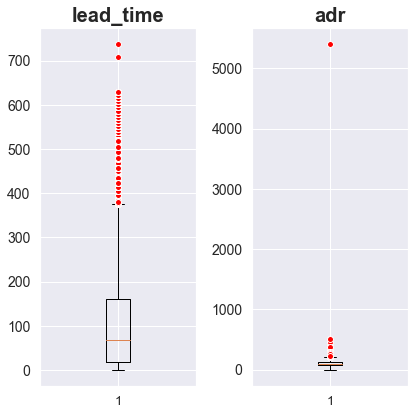

In [53]:
# creating subplot of each column
red_circle = dict(markerfacecolor = 'red',marker = 'o',markeredgecolor = 'white')
fig,axs = plt.subplots(1,2,figsize = (6,6))
for i,ax in enumerate(axs.flat):
    ax.boxplot(d_boxplot.iloc[:,i],flierprops = red_circle)
    ax.set_title(d_boxplot.columns[i],fontsize =20,fontweight = 'bold')
    ax.tick_params(axis = 'y',labelsize = 14)
plt.tight_layout()

There is an extreme value in the boxplot `adr` variable, and we can find that the value of `adr` reaches 5400 in a case. Morever, we find that there is one `adr` less than 0. Also it is reasonable that `adr` can be negative, but it is complicated when we do standardization, therefore we just delete it. Data types can be viewed after data processing.

In [16]:
d = d[~(d.adr ==5400)]
d = d[~(d.adr<-1)]

In [17]:
d.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 119203 entries, 0 to 119389
Data columns (total 30 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   is_canceled                     119203 non-null  int64  
 1   hotel                           119203 non-null  object 
 2   lead_time                       119203 non-null  int64  
 3   arrival_date_year               119203 non-null  int64  
 4   arrival_date_month              119203 non-null  object 
 5   arrival_date_week_number        119203 non-null  int64  
 6   arrival_date_day_of_month       119203 non-null  int64  
 7   stays_in_weekend_nights         119203 non-null  int64  
 8   stays_in_week_nights            119203 non-null  int64  
 9   adults                          119203 non-null  int64  
 10  children                        119203 non-null  float64
 11  babies                          119203 non-null  int64  
 12  meal            

The variable `children` should be integer variable, so we need to change the type the variable.

In [18]:
# Changing children to integer type: 
d['children'] = d['children'].astype(int)

In [19]:
d_raw = d.copy()

After solving the problems of missing data, duplication and extreme value, we should analyze the correlation between numerical variables and cancellation.

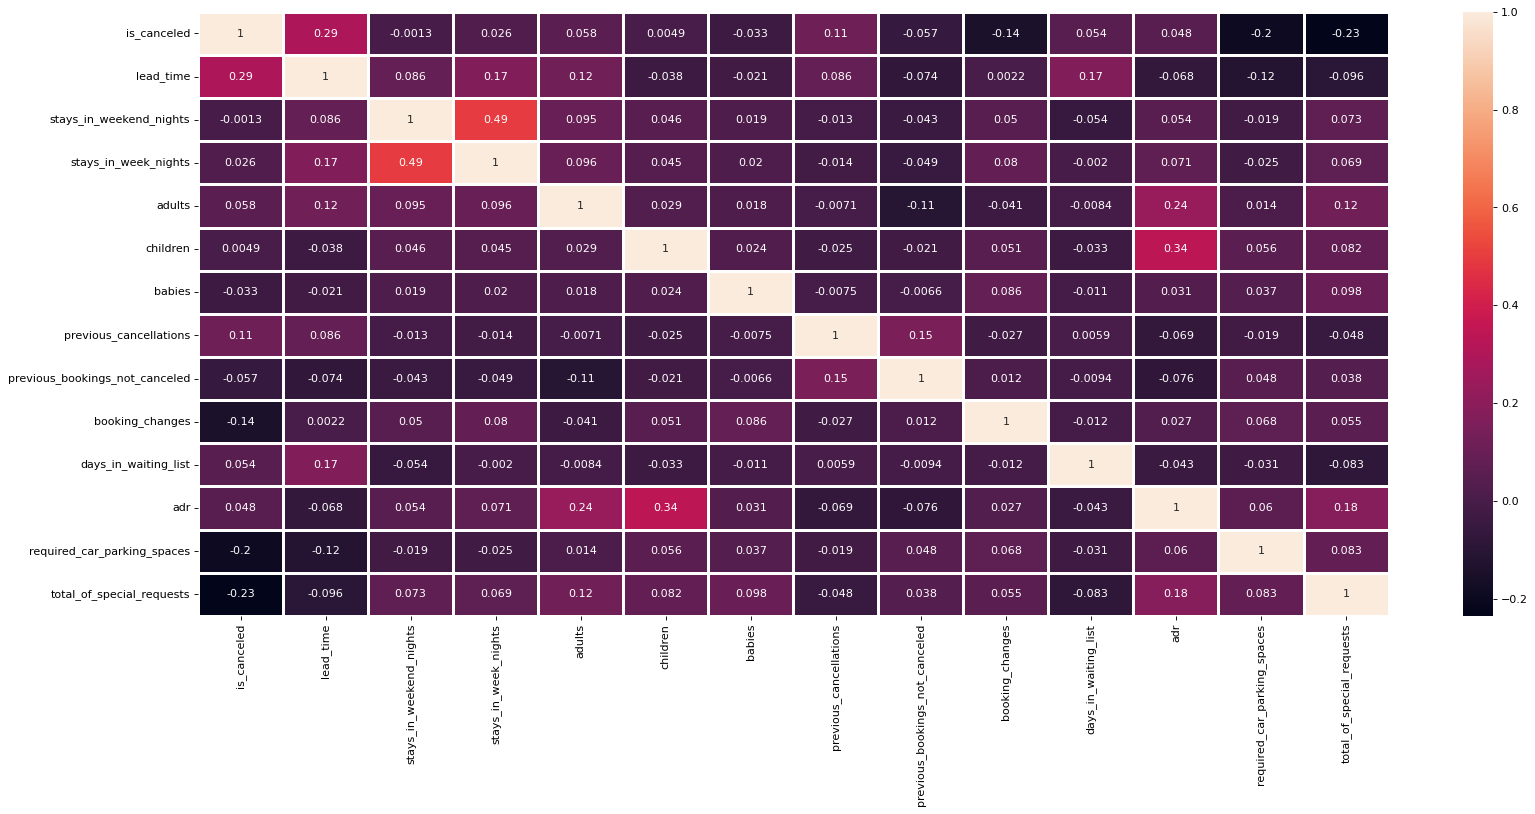

In [20]:
# Visualizing correlation coefficients between features and cancellation:
plt.figure(figsize=(24,10))
d_corr = d.copy()
d_corr.drop(columns = obj_cols, inplace= True)
corr = d_corr.corr()
sns.heatmap(corr,annot = True,linewidths = 1)
plt.show()

Since there are not variables that the correlation is larger than 0.6, we do not need to delete the variables.

- According to the graph, `lead_time` is the most highly correlated variable of the `is_canceled`. If the number of days that elapsed between the entering date of the booking into the PMS and the arrival date is larger, they will be more likely to meet unforeseen circumstances and the possibility of cancelling the booking is larger.
- `previous_cancelations` is the second feature with the strongest positive correlation to the `is_canceled`. When the number of previous_cancelations made increases, the customers are prior to canceling the booking. However,  `previous_bookings_not_canceled` does not correlate closely with `is_canceled`.
- `total_of_special_requests` and `required_car_parking_spaces` are variables with the strongest negative correlation to the `is_canceled`. If the guests make more interact with the hotel, they are less likely to cancel the reservation. We can conclude that the service prior to arrival is efficient to impress the customers.

After extract all numeric variables and see their distributions, we can conclude that all numerical variables are skewed.

Visualize the number of cancelled and not cancelled by date.

In [21]:
# Creating the arrival date full feature: 
d_draw = d
d_draw['exact_arrival_date'] = d['arrival_date_year'].astype(str) + "-" + d['arrival_date_month'].map({'January':1, 'February':2, 'March':3, 'April':4, 'May':5, 'June':6, 'July':7, 'August':8, 'September':9, 'October':10, 'November':11, 'December':12}).astype(str) + "-" + d['arrival_date_day_of_month'].astype(str)
d_draw['exact_arrival_date'] = pd.to_datetime(d_draw['exact_arrival_date'], format="%Y-%m-%d")

Text(0.5, 1.0, 'Number of Bookings by Month')

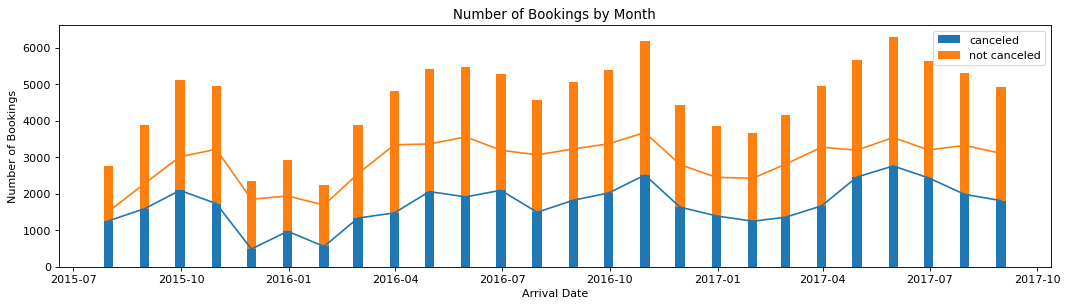

In [22]:
# create a dataframe of cancelled orders
canceled = d_draw[d_draw['is_canceled']==1][['exact_arrival_date']]
canceled.set_index('exact_arrival_date',inplace = True)
canceled['count'] =1
# aggregated by month
canceled = canceled.resample('M').sum()
# create a dataframe of not canceled orders
not_canceled = d_draw[d_draw['is_canceled']==0][['exact_arrival_date']]
not_canceled.set_index('exact_arrival_date',inplace = True)
not_canceled['count'] =1
# aggregated by month
not_canceled = not_canceled.resample('M').sum()
#visualize the number of canceled and not canceled bookings by date:
plt.figure(figsize=(16,4))
plt.bar(canceled.index,canceled['count'], width = 8, label = 'canceled')
plt.bar(canceled.index,not_canceled['count'],bottom  = canceled['count'], width = 8, label = 'not canceled')
sns.lineplot(x=canceled.index,y=canceled['count'])
sns.lineplot(x=not_canceled.index,y=not_canceled['count'])

plt.legend()
plt.ylabel('Number of Bookings')
plt.xlabel('Arrival Date')
plt.title('Number of Bookings by Month')

- The number of cancelled orders and not cancelled orders has similar trends.
- In the spring, the number of cancelled orders and not cancelled orders will climb up. More orders are canceled between April and July and the curve drops in summer. Then, the curve continues to increase and reaches the apex between October and November. After the  peak, the curve declines until the next spring comes.

Morever, we can compare the cancelled orders between two hotels.

Text(0, 0.5, 'Percentage of Bookings Canceled')

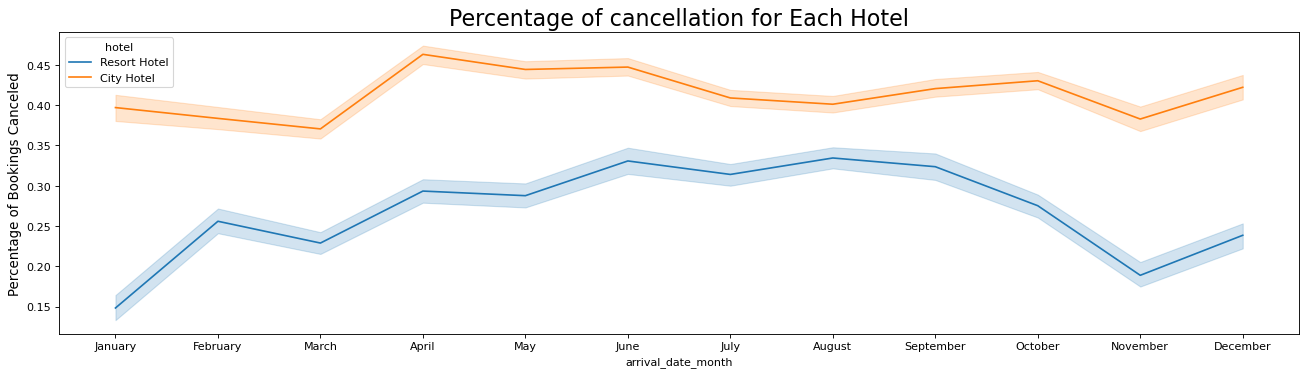

In [23]:
## Check the cancellation percentage with the Month for each hotel
import seaborn as sns
d_month_order = d
d_month_order['arrival_date_month'] = pd.Categorical(d['arrival_date_month'],
                                   categories=["January", "February", "March", "April", "May", "June", "July", "August", "September", "October", "November", "December"],
                                   ordered=True)
plt.figure(figsize=(20,5)) 
plt.title("Percentage of cancellation for Each Hotel", fontsize = 20)
sns.lineplot(data = d_month_order, x = "arrival_date_month", y = "is_canceled", hue = "hotel")
plt.ylabel("Percentage of Bookings Canceled", fontsize = 12)


It shows that the city hotel has more cancellation rate compared with the Resort Hotel. For City Hotel, the cancellation rate reaches a peak from April to June, during the spring period. For Resort Hotel, the peak arrives from June to August, during the summer period. Therefore, we need to take the influence of the month into consideration.

### 2.2 Feature Engineering

### 2.21 The relationship between categorical variables and cancellation rates

We want to use images to reflect the relationship between different categorical variables and cancellation rates, and picking out the appropriate variables as dummy variables.

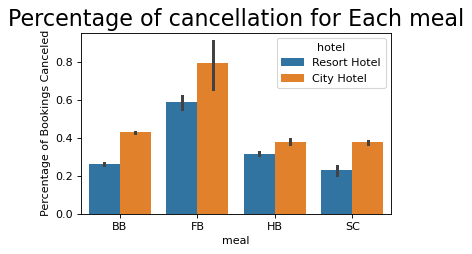

In [24]:
## Check the cancellation percentage with the meal
plt.figure(figsize = (5,3))
plt.title("Percentage of cancellation for Each meal", fontsize = 20)
sns.barplot(data = d, x = "meal", y = "is_canceled", hue = "hotel")
plt.ylabel("Percentage of Bookings Canceled", fontsize = 10)
plt.show()

Here we can see different meal types have different cancellation percentages, so this feature variable needs to be taken into consideration.

According to the graph below, the guests from Senegal, Honduras, Benin, Saudi Arabia, Tajikistan, United Arab Emirates, etc. Some European and African countries have lower cancelation rates compared with other distant countries. Note that Because both hotels are located in Portugal, it seems that countries that are closer to the hotels are not prior to canceling the hotels.

In [25]:
plt.style.use('fivethirtyeight')
%matplotlib inline
plt.figure(figsize = (10,8))
pd.set_option('display.max_columns', 32)

# create the map for the customers from different countries.
# calculate the percentage of cancellation among different countries
country_customers = (d.groupby(['country'])['is_canceled'].sum()/(d.groupby(['country'])['is_canceled'].count())).reset_index()
country_customers.columns = ['country','percentage of cancelled']
basemap = folium.Map()
customer_map = px.choropleth(country_customers,
                            locations = country_customers['country'],
                            color = country_customers['percentage of cancelled'],
                            hover_name = country_customers['country'],
                            color_continuous_scale = 'portland')
customer_map.show()

<Figure size 720x576 with 0 Axes>

Text(0, 0.5, 'Percentage of Bookings Canceled')

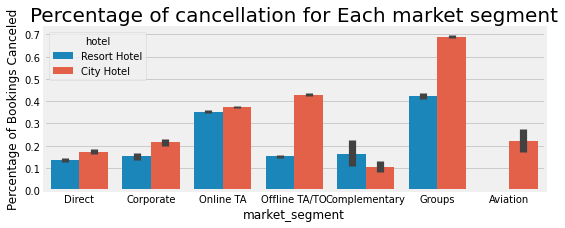

In [26]:
## Check the cancellation percentage with the market segment
plt.figure(figsize = (8,3))
plt.title("Percentage of cancellation for Each market segment", fontsize = 20)
sns.barplot(data = d, x = "market_segment", y = "is_canceled", hue = "hotel")
plt.ylabel("Percentage of Bookings Canceled", fontsize = 12)

Here we can see different `market segment` types have different cancellation percentages. We discover that City Hotel has a higher percentage of cancellations in this feature compared to Resort Hotel, so this feature variable needs to be taken into consideration. 

Text(0, 0.5, 'Percentage of Bookings Canceled')

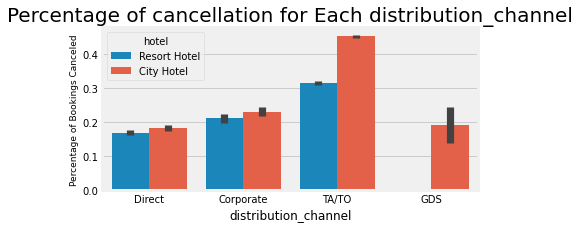

In [27]:
## Check the cancellation percentage with the distribution channel
plt.figure(figsize = (6,3))
plt.title("Percentage of cancellation for Each distribution_channel", fontsize =20)
sns.barplot(data = d, x = "distribution_channel", y = "is_canceled", hue = "hotel")
plt.ylabel("Percentage of Bookings Canceled", fontsize = 9)

Here we can see different `distribution_channel` types have different cancellation percentages. We discover that City Hotel has a higher percentage of cancellations in this feature compared to Resort Hotel, so this feature variable needs to be taken into consideration. 

Text(0, 0.5, 'Percentage of Bookings Canceled')

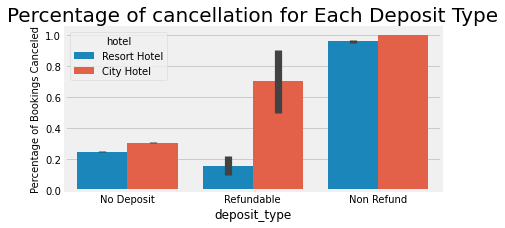

In [28]:
## Check the cancellation percentage with the deposit type
plt.figure(figsize = (6,3))
plt.title("Percentage of cancellation for Each Deposit Type", fontsize = 20)
sns.barplot(data = d, x = "deposit_type", y = "is_canceled", hue = "hotel")
plt.ylabel("Percentage of Bookings Canceled", fontsize = 10)

It is quite strange that people who pay the non-refund deposit tends to cancel their bookings. it needs to be discussed in the further research.

In [29]:
agent_count = (d.groupby(['agent'])['is_canceled'].sum()/d.groupby(['agent'])['is_canceled'].count()).reset_index()
agent_count['count'] = ((d.groupby(['agent'])['is_canceled'].count()).reset_index())['is_canceled'] 
agent_count.columns = ['agent','percentage of canceled','count']
agent = agent_count[agent_count['count']>50].sort_values(by = 'percentage of canceled',ascending = False)[0:10]
agent.set_index('agent')

,percentage of canceled,count
agent,,
236.0,1.000000,247
170.0,1.000000,93
41.0,1.000000,75
326.0,0.975758,165
31.0,0.950617,162
58.0,0.880597,335
495.0,0.877193,57
29.0,0.800587,682
44.0,0.794521,292


Here we list the first ten agents that have the highest cancellation rate, at the same time the agents' count less than 50 times do not take into consideration. And the table above is our result. The first column is the `agent` code.

In [30]:
company_count = (d.groupby(['company'])['is_canceled'].sum()/d.groupby(['company'])['is_canceled'].count()).reset_index()
company_count['count'] = ((d.groupby(['company'])['is_canceled'].count()).reset_index())['is_canceled'] 
company_count.columns = ['company','percentage of canceled','count']
company = company_count[company_count['count']>50].sort_values(by = 'percentage of canceled',ascending = False)[0:10]
company.set_index('company')

,percentage of canceled,count
company,,
348.0,1.000000,59
67.0,0.655431,267
No Company,0.382559,112435
51.0,0.353535,99
110.0,0.326923,52
135.0,0.287879,66
498.0,0.275862,58
169.0,0.250000,64
153.0,0.225352,213


Here we list the first ten companies that have the highest cancellation rate, at the same time the companies' count less than 50 times do not take into consideration. And the table above is our result. The first column is the `company` code.

Text(0, 0.5, 'Percentage of Bookings Canceled')

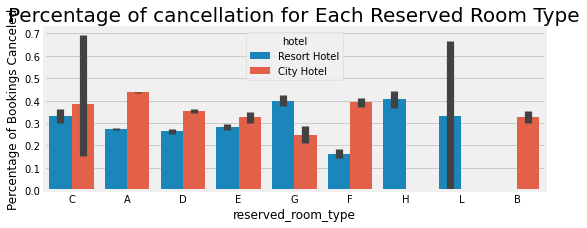

In [31]:
## Check the cancellation percentage with the room type
plt.figure(figsize = (8,3))
plt.title("Percentage of cancellation for Each Reserved Room Type", fontsize = 20)
sns.barplot(data = d, x = "reserved_room_type", y = "is_canceled", hue = "hotel")
plt.ylabel("Percentage of Bookings Canceled", fontsize = 12)

Here we can conclude that different `Reserved Room Type` have different precentage of cancelations. Thus this feature variables need to be taken into consideration.

Text(0, 0.5, 'Percentage of Bookings Canceled')

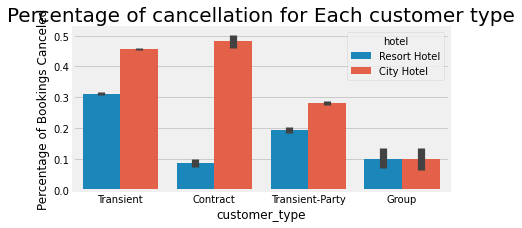

In [32]:
## Check the cancellation percentage with the customer type
plt.figure(figsize = (6,3))
plt.title("Percentage of cancellation for Each customer type", fontsize = 20)
sns.barplot(data = d, x = "customer_type", y = "is_canceled", hue = "hotel")
plt.ylabel("Percentage of Bookings Canceled", fontsize = 12)

Here we can see that for `Contract customer` City Hotel cancellation rate is quite higher than Resort Hotel, so we tend to take this feature variable into consideration.

In [33]:
# Here we set all categorical variables as dummmy variables
fea_dummy = pd.get_dummies(d[obj_cols].astype(str), drop_first=True)

In [34]:
d_num = d[num_cols]
# transfrom any skewed features using a log transform

lt = LogTransformer(variables = num_cols)
d_num_1 = d_num[num_cols]+1
X_num_lt = lt.fit_transform(d_num_1) # to stop the 0 value error

In [35]:
X = pd.concat([X_num_lt,fea_dummy],axis = 1)
X.head()

,lead_time,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,previous_cancellations,previous_bookings_not_canceled,booking_changes,days_in_waiting_list,adr,required_car_parking_spaces,total_of_special_requests,arrival_date_year_2016,arrival_date_year_2017,arrival_date_week_number_10,...,country_UGA,country_UKR,country_UMI,country_URY,country_USA,country_UZB,country_VEN,country_VGB,country_VNM,country_ZAF,country_ZMB,country_ZWE,country_unknown,customer_type_Group,customer_type_Transient,customer_type_Transient-Party
0,5.837730,0.0,0.000000,1.098612,0.0,0.0,0.0,0.0,1.386294,0.0,0.000000,0.0,0.000000,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1,6.603944,0.0,0.000000,1.098612,0.0,0.0,0.0,0.0,1.609438,0.0,0.000000,0.0,0.000000,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2,2.079442,0.0,0.693147,0.693147,0.0,0.0,0.0,0.0,0.000000,0.0,4.330733,0.0,0.000000,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
3,2.639057,0.0,0.693147,0.693147,0.0,0.0,0.0,0.0,0.000000,0.0,4.330733,0.0,0.000000,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
4,2.708050,0.0,1.098612,1.098612,0.0,0.0,0.0,0.0,0.000000,0.0,4.595120,0.0,0.693147,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


# 3. Model Fitting and Tuning

First，divide the samples into training set and test set. Here, we use the additional argument inside of `train_test_split` function, stratify in terms of the response data set to make sure the class proportions in train and testing will be the same. 

In [36]:
y = d['is_canceled']
# get our null accuracy rate 
print(y.value_counts(normalize=True)*100)

#Stratified sampling on whether the booking was canceled (1) or not (0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1, stratify=y)

0    62.92543
1    37.07457
Name: is_canceled, dtype: float64


The main goal of our model building is to get a model with higher prediction accuracy. At the same time, we also want to understand what aspects of a booking affect the likelihood of it being canceled. In order to do so, we compare the model in logistic regression, a decision tree, a random forest, and a neural network.

### 3.1 Logistic Regression

First, we use logistic regression to fit the data.

In [37]:
#make a pipieline for logostic regression
log_pipe = make_pipeline(StandardScaler(), LogisticRegression(random_state=42, penalty="none"))
logfit = log_pipe.fit(X_train, y_train)

# print(logfit.get_params())
print(logfit.score(X_train,y_train))
print(logfit.score(X_test,y_test))

0.8503751108554445
0.844495400016778


This model is not overfit or underfit (the training and testing scores are close together). The model is outperforming the baseline with a testing accuracy of 80.8%. However, the prediction accuracy of the model is not very high, then we want to get the confusion matrix to find details about the prediction.

Report for Logistic Regression:
               precision    recall  f1-score   support

           0       0.86      0.90      0.88     22503
           1       0.82      0.75      0.78     13258

    accuracy                           0.84     35761
   macro avg       0.84      0.82      0.83     35761
weighted avg       0.84      0.84      0.84     35761



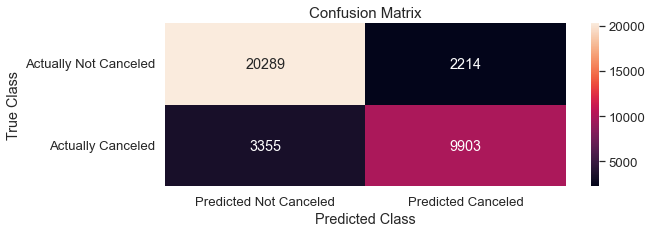

In [38]:
log_pipe2 = make_pipeline(StandardScaler(), LogisticRegression(C=4.23, random_state=42,max_iter=100))
logfit2 = log_pipe2.fit(X_train,y_train)
# predict the test data
y_test_pred_log =  logfit2.predict(X_test)
# Creating confusion matrix 
log_cm = sklearn.metrics.confusion_matrix(y_test,y_test_pred_log)
# putting the matrix a dataframe form  
log_cm_df = pd.DataFrame(log_cm, index=['Actually Not Canceled', 'Actually Canceled'],
                 columns=['Predicted Not Canceled', 'Predicted Canceled'])
# visualizing the confusion matrix
sns.set(font_scale=1.2)
plt.figure(figsize=(8,3))
sns.heatmap(log_cm, annot=True, fmt='g',xticklabels=log_cm_df.columns,yticklabels=log_cm_df.index)
# summary the prediction performance
log_report = classification_report(y_test, y_test_pred_log)
print(f'Report for Logistic Regression:\n',log_report)
plt.title("Confusion Matrix", size=15)
plt.xlabel('Predicted Class')
plt.ylabel('True Class');

Here, the confusion matrix content implies an important issue about the values of FN. But we care more about FP, we don not want to have a double book issue for our customers. The accuracy for Logistic Regression is 0.84.

### 3.2 Decision Tree

Decision Trees (DTs) are a non-parametric supervised learning method. A decision tree uses a tree-like model of decisions and the possible results and is always used as the best choice model or selection model. 

Report for Decision Tree:
               precision    recall  f1-score   support

           0       0.89      0.89      0.89     22503
           1       0.81      0.82      0.82     13258

    accuracy                           0.86     35761
   macro avg       0.85      0.85      0.85     35761
weighted avg       0.86      0.86      0.86     35761



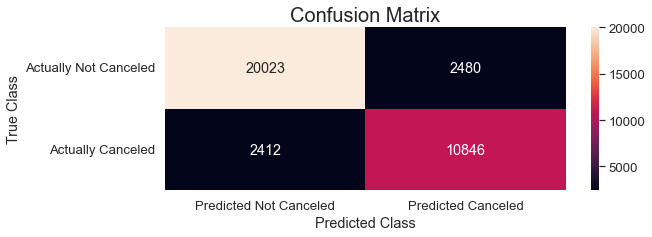

In [39]:
# Decision Tree
dt = DecisionTreeClassifier(random_state=0).fit(X_train,y_train)
# predict the test data
y_test_pred_dt = dt.predict(X_test)
conf_matrix_dt = confusion_matrix(y_test,y_test_pred_dt)
# putting the matrix a dataframe form  
dt_cm_df = pd.DataFrame(conf_matrix_dt, index=['Actually Not Canceled', 'Actually Canceled'],columns=['Predicted Not Canceled', 'Predicted Canceled'])
# visualizing the confusion matrix
plt.figure(figsize=(8,3))
sns.heatmap(conf_matrix_dt,annot=True,fmt='g',xticklabels=dt_cm_df.columns,yticklabels=dt_cm_df.index)
plt.title("Confusion Matrix", size=20)
plt.xlabel('Predicted Class')
plt.ylabel('True Class');
# summary the prediction performance
clf_report_dt = classification_report(y_test, y_test_pred_dt)
print(f'Report for Decision Tree:\n',clf_report_dt)

The accuracy of this method is 0.86, which is better than the previous models. The confusion matrix shows that it has similar number of FP and FN. We want to find whether there would be a better model than decision trees, so we try a Random Forest next, which is a ensemble learning method for classification based on decision trees.

### 3.3 Random Forest

Based on the decision trees, the random forest is a classification algorithm containing many decision trees.
The random forests usually outperform decision trees but the data characteristics may affect the final results. So, we need to test whether the accuracy of random forests is better than decision trees.

Report for Random Forest:
               precision    recall  f1-score   support

           0       0.89      0.95      0.92     22503
           1       0.90      0.80      0.85     13258

    accuracy                           0.89     35761
   macro avg       0.89      0.87      0.88     35761
weighted avg       0.89      0.89      0.89     35761



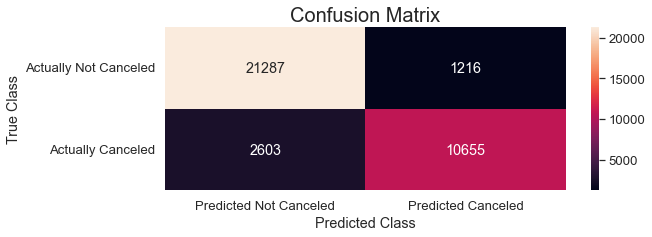

In [40]:
# Random Forest
rf = RandomForestClassifier(random_state=42).fit(X_train,y_train)
rf.fit(X_train,y_train)
# predict the test data
y_test_pred_rf = rf.predict(X_test)

conf_matrix_rf = confusion_matrix(y_test,y_test_pred_rf)
# putting the matrix a dataframe form  

rf_cm_df = pd.DataFrame(conf_matrix_rf, index=['Actually Not Canceled', 'Actually Canceled'],
                 columns=['Predicted Not Canceled', 'Predicted Canceled'])
# visualizing the confusion matrix
plt.figure(figsize=(8,3))
sns.heatmap(conf_matrix_rf,annot=True,fmt='g',xticklabels=rf_cm_df.columns,yticklabels=rf_cm_df.index)
plt.title("Confusion Matrix", size=20)
plt.xlabel('Predicted Class')
plt.ylabel('True Class');
# summary the prediction performance
clf_report_rf = classification_report(y_test, y_test_pred_rf)
print(f'Report for Random Forest:\n',clf_report_rf )

The result shows that this classifier has better performance and the accuracy is 0.89. And the Random Forest has significantly less number of FP, it would be helpful on our goal since more FP would result in more loss for the hotels.

Here, we draw ROC curve for the this model.

In [41]:
# Function from week-7 exercise 
def roc_plot(threshold=0.5):
    i = (np.abs(roc.threshold - threshold)).idxmin()
    sns.lineplot(x='false positive rate', y='true positive rate', data=roc, ci=None)
    plt.plot([0,1],[0,1], 'k--', alpha=0.5) # 0-1 line 
    plt.plot(roc.iloc[i,0], roc.iloc[i,1], 'r.')
    plt.title("threshold = %.2f" % threshold)
    plt.show()

(array([0.        , 0.05403724, 1.        ]), array([0.        , 0.80366571, 1.        ]), array([2, 1, 0], dtype=int64))
   false positive rate  true positive rate  threshold
0             0.000000            0.000000        2.0
1             0.054037            0.803666        1.0
2             1.000000            1.000000        0.0
AUC value: 0.8242791794301715


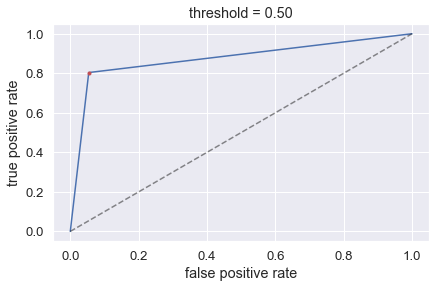

In [42]:
roc_calc = roc_curve(y_true = y_test, y_score = y_test_pred_rf)
print(roc_calc)
roc = pd.DataFrame(
    data = np.c_[roc_calc],
    columns = ('false positive rate', 'true positive rate', 'threshold')
)
# Values for ROC based on different threshold 
print(roc)
#Print the related AUC value 
print("AUC value:", roc_auc_score(y_true = y_test, y_score = y_test_pred_log))
#ROC curve drawing by using the helper function roc_plot above
roc_plot(threshold=0.5)

The ROC plot shows that the Random Forest performs well in prediction the test data. And then we try to get the most important features in the Random Forest.

In [43]:
# extract feature importance
fi = pd.DataFrame({'feature':list(X_test.columns),
          'importance':rf.feature_importances_}).\
          sort_values('importance',ascending=False)

# obtain the first 10 important variables
fi[0:10]

,feature,importance
0,lead_time,0.092707
140,deposit_type_Non Refund,0.066938
957,country_PRT,0.066326
10,adr,0.057958
12,total_of_special_requests,0.052452
2,stays_in_week_nights,0.031678
6,previous_cancellations,0.028142
1,stays_in_weekend_nights,0.020734
11,required_car_parking_spaces,0.018805
8,booking_changes,0.017884


After combing the heatmap and bar chart from exploratory data analysis, we can find the trend for these important features. 

For those numerical variables, it can be concluded that when we increase`lead_time`,`adr`,`stays_in_week_nights`, the more likely the customer will cancel the reservation. But when we increase `total_of_special_requests`,`required_car_parking_spaces`,`booking_changes`, the more likely the customer will keep the reservation.
For categorical variables, when the `deposit_type` is Non_Refund, and `country` is PRT, the possibility of cancellation will increase.

### 3.4 Artificial Neural Network

ANNs are conceptually derived from biological neurons. We need to take the weighted sum of all the features, add a bias term to the sum and then pass through an activation function to output the results. The final outputs can accomplish our task which is predicting the cancelation conditions in our report. 
Finally, we try to use Artificial Neural Network on our datasets.

In [44]:
X1 = X
y1 = to_categorical(d['is_canceled'])

In [45]:
# splitting data into training set and test set
X_train1, X_test1, y_train1, y_test1 = train_test_split(X1, y1, test_size = 0.30)

model  = Sequential()
model.add(Dense(100, activation = 'relu', input_shape = (1003, )))
model.add(Dense(100, activation = 'relu'))
model.add(Dense(2, activation = 'sigmoid'))
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
model_history = model.fit(X_train1, y_train1, validation_data = (X_test1, y_test1),
                          epochs = 20)
clear_output()

In [46]:
plt.figure(figsize = (12, 6))

train_acc = model_history.history['accuracy']
val_acc = model_history.history['val_accuracy'] 
epoch = range(1, 21)


accuracy = pd.DataFrame({'train_acc' : train_acc, 'val_acc' : val_acc})

px.line(data_frame = accuracy, x = epoch, y = ['val_acc', 'train_acc'], title = 'Training and Validation Accuracy',
        template = 'plotly_dark')

<Figure size 864x432 with 0 Axes>

In [47]:
acc_ann = model.evaluate(X_test1, y_test1)[1]

print(f'Accuracy of model is {acc_ann}')

1118/1118 [==============================] - 1s 542us/step - loss: 0.3844 - accuracy: 0.8723
Accuracy of model is 0.8722910284996033


After training, the accuracy of the model is 0.87, which is lower than the Random Forest.

### 3.5 Understanding Misclassification 

After comparing those models, we decide to use the Random Forest as our final classification method. And we want to address the perfomance in terms of potential gains and losses for the hotel.

First, we want to check if our model predicts a cancelation that does not actually occur and a room ends up being double booked.

In [48]:
# Creating a dataframe to compare our predictions with our actual output
d_cancel = pd.DataFrame(y_test)
d_cancel['prediction'] = y_test_pred_rf

pre_analysis = pd.merge(left=d_cancel, right=X_test, on=d_cancel.index)
pre_analysis = pre_analysis.set_index('key_0')
pre_false = pre_analysis[pre_analysis['is_canceled'] != pre_analysis['prediction']]
pre_false_fp = pre_false[(pre_false['is_canceled']==0) & (pre_false['prediction']==1)]

In [49]:
#calculate the potential gains we obtained
d_fp = d.loc[pre_false_fp.index]
d_fp['total_nights'] = (d_fp['stays_in_weekend_nights']).add(d_fp['stays_in_week_nights'])
sum((d_fp['total_nights'])*d_fp['adr'])

616813.0299999996

If there is a new appointment on the predicted canceled room, we could prevent the loss.

But if our prediction is wrong, there would be conflictions in reservation and we would lose some customers. 

In [50]:
# obtain the test data
pre_false_fn = pre_false[(pre_false['is_canceled']==1) & (pre_false['prediction']==0)]

#obtain the original data for model predicts no cancelation but actually canceled according to the index
d_fn = d.loc[pre_false_fn.index]

#calculate the money we lose 
d_fn['total_nights'] = (d_fn['stays_in_weekend_nights']).add(d_fn['stays_in_week_nights'])
sum((d_fn['total_nights'])*d_fn['adr'])

1056563.7599999986

We will lose 1056563 and these room end up being empty since we reserved the room for those canceled room.

## 4. Discussion & Conclusions


**Discussion**


After testing the accuracy of logistic regression, decision tree, artificial neural network and random forest, we finally selected the random forest with the highest test accuracy at 89%, which is higher by at least 3% than other models.

 In terms of model interpretation, `lead time`, `deposit type country`, `adr`, and `total_of_special_requests` are significant in the final model. It shows that when the numerical variables `lead_time` and `adr` increase, the customer tends to cancel their reservation. In the meantime, categorical variables like deposit type are Non_refund, and the country of customers come from is  PRT, which will also increase the likelihood that the customer will cancel the order. Therefore, evaluating the customer's deposit type and country of origin can effectively predict the occurrence of cancellations.However, the value of `total_of_special_requests` has a completely different tendency towards customer cancellations. With more requests, customers are less likely to cancel their orders. 

Finally, we tested the model's effect on performance when the predictions of random forest were wrong. When customers cancel the order, but the model predicts with no cancellation, we have XX loss. When customers do not cancel an order, and the model predicts cancellation, double booking occurs, which has a greater impact on revenue. 

**Conclusion**


In conclusion, we try to use *random forest model* to predict the hotel cancellation and its correct prediction rate for the tested set reaches 89%, which is quite good. These features, `lead time`, `deposit type country`, `adr`, and `total_of_special_requests` are the most important features in the model. For the assessment of our model performance, we try to calculate the gain or loss when the booking is missing arranged. This amount is the `total stay days` $*$ `adr`, for the model predicts a cancellation that does not actually occur and a room ends up being double-booked, the loss is **616,813**, for the model predicts a cancellation that room ends up being empty since we reserved the room for those canceled rooms, the loss is **1,056,563**. As a result, our model can reach 89% correct prediction and analysis of the loss when miss-arranged. 